# Testing attribution methods with MNIST dataset via DNNs to duplicate work in source paper

In [1]:
# Automatically reload imported symbols when external .py are modified
get_ipython().run_line_magic("load_ext", "autoreload")
get_ipython().run_line_magic("autoreload", "2")

In [2]:
import os, sys

# Allow this notebook to be aware of library structure
GetPath = lambda s: os.path.dirname(os.path.abspath(s))
paths = ["", "attrmethods/lrp", "attrmethods/deeplift"]
[sys.path.append(GetPath(p)) for p in paths if not GetPath(p) in sys.path]


import torch

# Validate Metal API for Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(torch.ones(1, device=device))
else:
    print("MPS device not found. Using CPU.")
    device = torch.device("cpu")

tensor([1.], device='mps:0')


### Get MNIST dataset 

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST("data", True, ToTensor(), download=True)
test_data = datasets.MNIST("data", False, ToTensor())

for data in [train_data, test_data]:
    data.data.to(torch.device(device)).float().requires_grad_()
    data.targets.to(torch.device(device)).float().requires_grad_()

### Assemble loaders for optional batching

In [4]:
loader_args = {
    "batch_size": 600,
    "shuffle": True,
    "num_workers": 1,
    "generator": torch.Generator(device=device),
}
loaders = {
    "train": torch.utils.data.DataLoader(train_data, **loader_args),
    "test": torch.utils.data.DataLoader(test_data, **loader_args),
}

### Setup DNNs

In [5]:
from dnn import DNN

dnn = DNN().to(device)

### Train

In [6]:
# Train model for `epochs` epochs
def Train(model, epochs, model_filename, do_train, device):
    if os.path.isfile(model_filename):
        print(f"Found trained model file {model_filename}")
        if not do_train:
            model.load_state_dict(
                torch.load(model_filename, map_location=torch.device(device))
            )
            print(f"Trained model file loaded")
            return
    print(f"Training for {epochs:.0f} epochs...")
    model.train_model(epochs, loaders, device)
    print(f"Training complete. Saving model")
    torch.save(model.state_dict(), model_filename)
    print(f"Done")


epochs = 10
Train(
    model=dnn,
    epochs=epochs,
    model_filename=f"models/minst_dnn_{epochs:.0f}_epochs_tanh_no_bias.pt",
    do_train=False,
    device=device,
)

Found trained model file models/minst_dnn_10_epochs_tanh_no_bias.pt
Trained model file loaded


### Test DNN

In [7]:
def test(model, test_loader):
    with torch.device(device):
        model.eval()

        accuracy = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images.to(device).float().requires_grad_())
                classification = torch.max(outputs.detach().cpu(), 1)[1].data.squeeze()

                accuracy += (classification == labels).sum().item() / labels.size(0)

    return accuracy / len(test_loader)


print(f"Accuracy: {test(dnn, loaders["test"]):.3f}")

Accuracy: 0.906


### Attribute generation

Label: 3


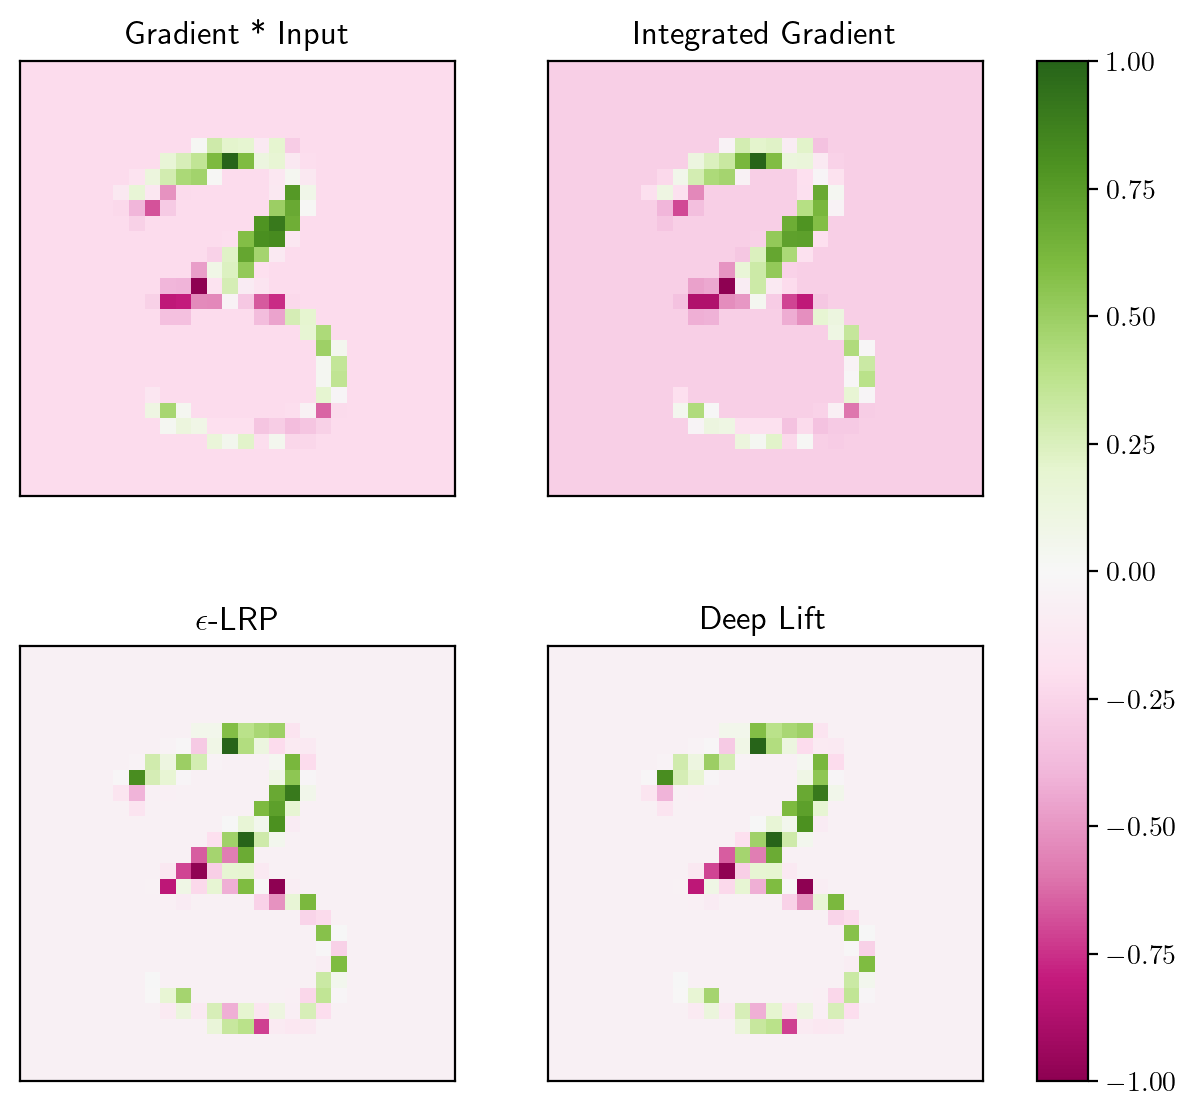

In [9]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["text.usetex"] = True

from attrmethods.epsilon_lrp import EpsilonLRP
from attrmethods.deep_lift import DeepLift
from attrmethods.gradient_input_product import GradientInputProduct
from attrmethods.integrated_gradient import IntegratedGradient

Normalize = lambda x: 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1

with torch.device(device):
    images, labels = next(iter(loaders["test"]))
    images = images.to(device).float().requires_grad_()
    label = int(labels[0])
    print(f"Label: {label}")

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), dpi=200)
    fig.tight_layout()

    cmap = mpl.colormaps["PiYG"]

    method_dict = [
        (GradientInputProduct, "Gradient * Input"),
        (IntegratedGradient, "Integrated Gradient"),
        (EpsilonLRP, r"$\epsilon$-LRP"),
        (DeepLift, "Deep Lift"),
    ]

    for ax, (Method, title) in zip(axs.flat, method_dict):
        attrs = Method(images[0], label, dnn, device)
        sc = ax.imshow(Normalize(attrs.detach().cpu().numpy()[0]), cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_xticks([])
    fig.colorbar(sc, ax=axs.ravel().tolist(), fraction=0.04777)